In [1]:
import os.path as op
import os
import numpy as np
import pandas as pd

bids_folder = '/Users/mrenke/data/ds-dnumrisk'


In [2]:
from utils_02 import build_model
from utils import get_data
import arviz as az

df = get_data()

format = 'symbolic'
model_label = '4'

df = df.xs(format,0, level='format')


number of subjects in dataframe: 66
Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66],
           dtype='int64', name='subject')


In [3]:
specification = 'sub1-10'
subList = [1,2,3,4,5,6,7,8,9,10]
df = df.loc[df.index.get_level_values('subject').isin(subList)] # only 10 subs to check model fitting

df['choice'] = df['chose_risky'] ##
df.head()
df.to_csv(op.join(bids_folder, 'interim_sum_data', f'risk-data_{specification}.csv'))

In [76]:
from bauer.utils.data import load_garcia2022

df_mig = load_garcia2022(task='risk')
df_mig.head()
df = df[df_mig.columns.values]

p1  n1    p2  n2  log(risky/safe)  choice
subject format   run trial_nr                                            
1       symbolic 1   1         1.0  14  0.55  47         1.211090    True
                     2         1.0   5  0.55   6         0.182322   False
                     3         1.0  14  0.55  17         0.194156   False
                     4         1.0  10  0.55  12         0.182322   False
                     5         1.0  14  0.55  28         0.693147    True

In [83]:
df.to_csv(op.join(bids_folder, 'interim_sum_data', f'risk-data_{specification}.csv'))

In [4]:
from bauer.models import RiskLapseModel
model = RiskLapseModel(df, 
                            #regressors = {'p_lapse':'group','prior_sd':'group','evidence_sd':'group'},
                            prior_estimate = 'klw',
                            fit_seperate_evidence_sd = False,
                            )

model.build_estimation_model()

### try model fitting

In [33]:
target_folder = op.join(bids_folder, 'derivatives', 'cogmodels_risk')

model_label = 'RiskLapseModel'

burnin=1000
samples=1000
model.build_estimation_model()
trace = model.sample(burnin, samples, target_accept=0.9)
az.to_netcdf(trace, '/Users/mrenke/Desktop/tryout_trace.netcdf')
                #op.join(target_folder, f'model-{model_label}_format-{format}_spec-{specification}trace.netcdf'))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [evidence_sd_mu_untransformed, evidence_sd_sd, evidence_sd_offset, prior_sd_mu_untransformed, prior_sd_sd, prior_sd_offset, p_lapse_mu_untransformed, p_lapse_sd, p_lapse_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 147 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 661 divergences after tuning. Increase `target_accept` or reparameterize.


'/Users/mrenke/Desktop/tryout_trace.netcdf'

### look at posteriors, e.g. PPCs

In [5]:
idata = az.from_netcdf(op.join(bids_folder, f'derivatives/cogmodels_risk/', f'model-{model_label}_format-{format}_trace.netcdf'))

In [7]:
idata.posterior

<xarray.Dataset>
Dimensions:                 (chain: 4, draw: 1000, evidence_sd_regressors: 2,
                             subject: 66, prior_sd_regressors: 2,
                             p_lapse_regressors: 2)
Coordinates:
  * chain                   (chain) int64 0 1 2 3
  * draw                    (draw) int64 0 1 2 3 4 5 ... 994 995 996 997 998 999
  * evidence_sd_regressors  (evidence_sd_regressors) object 'Intercept' 'group'
  * subject                 (subject) int64 13 14 22 25 49 40 ... 61 66 59 50 57
  * prior_sd_regressors     (prior_sd_regressors) object 'Intercept' 'group'
  * p_lapse_regressors      (p_lapse_regressors) object 'Intercept' 'group'
Data variables:
    evidence_sd_mu          (chain, draw, evidence_sd_regressors) float64 ...
    evidence_sd_offset      (chain, draw, subject, evidence_sd_regressors) float64 ...
    prior_sd_mu             (chain, draw, prior_sd_regressors) float64 ...
    prior_sd_offset         (chain, draw, subject, prior_sd_regressors) float64 ...
    p_lapse_mu              (chain, draw, p_lapse_regressors) float64 ...
    p_lapse_offset          (chain, draw, subject, p_lapse_regressors) float64 ...
    evidence_sd_sd          (chain, draw, evidence_sd_regressors) float64 ...
    prior_sd_sd             (chain, draw, prior_sd_regressors) float64 ...
    p_lapse_sd              (chain, draw, p_lapse_regressors) float64 ...
    evidence_sd             (chain, draw, subject, evidence_sd_regressors) float64 ...
    prior_sd                (chain, draw, subject, prior_sd_regressors) float64 ...
    p_lapse                 (chain, draw, subject, p_lapse_regressors) float64 ...
Attributes:
    created_at:                 2024-05-06T12:20:22.984943
    arviz_version:              0.14.0
    inference_library:          pymc
    inference_library_version:  5.6.1
    sampling_time:              1223.6663279533386
    tuning_steps:               1000

In [ ]:
# load in trace
specification = 'sub1-10'
#model.build_estimation_model()
idata = az.from_netcdf(  #'/Users/mrenke/Desktop/tryout_trace.netcdf') _spec-{specification}
    op.join(bids_folder, f'derivatives/cogmodels_risk/', f'model-{model_label}_format-{format}_trace.netcdf'))

In [58]:
#df['log(n2/n1)'] = np.log(df['n_risky'] / df['n_safe'])
ppc = model.ppc(idata=idata.sel(draw=slice(None, None, 10)), paradigm=df)
# needs the model 

Sampling: [ll_bernoulli]


In [64]:
ppc.index.get_level_values('choice').values

array([ True, False, False, ...,  True, False,  True])

In [67]:
ppc['format'] = format
ppc['chose_risky'] = ppc.index.get_level_values('choice').values
ppc = ppc.set_index(['format', 'chose_risky'], append=True)

df['format'] = format
df['chose_risky'] = df['choice']
df = df.set_index('format', append=True)

ppc.head()

chain                                                                                                                            0  \
draw                                                                                                                           0     
variable     subject format       run trial_nr p1  n1 p2   n2 log(risky/safe) choice format   chose_risky format   chose_risky       
ll_bernoulli 1       non-symbolic 1   1        1.0 14 0.55 47 1.211090        True   symbolic True        symbolic True          0   
                                      2        1.0 5  0.55 6  0.182322        False  symbolic False       symbolic False         0   
                                      3        1.0 14 0.55 17 0.194156        False  symbolic False       symbolic False         0   
                                      4        1.0 10 0.55 12 0.182322        False  symbolic False       symbolic False         1   
                                      5        1.0 14 0.55 28 0.693147        False  symbolic False       symbolic False         0   

chain                                                                                                                               \
draw                                                                                                                           10    
variable     subject format       run trial_nr p1  n1 p2   n2 log(risky/safe) choice format   chose_risky format   chose_risky       
ll_bernoulli 1       non-symbolic 1   1        1.0 14 0.55 47 1.211090        True   symbolic True        symbolic True          0   
                                      2        1.0 5  0.55 6  0.182322        False  symbolic False       symbolic False         1   
                                      3        1.0 14 0.55 17 0.194156        False  symbolic False       symbolic False         0   
                                      4        1.0 10 0.55 12 0.182322        False  symbolic False       symbolic False         0   
                                      5        1.0 14 0.55 28 0.693147        False  symbolic False       symbolic False         0   

chain                                                                                                                               \
draw                                                                                                                           20    
variable     subject format       run trial_nr p1  n1 p2   n2 log(risky/safe) choice format   chose_risky format   chose_risky       
ll_bernoulli 1       non-symbolic 1   1        1.0 14 0.55 47 1.211090        True   symbolic True        symbolic True          1   
                                      2        1.0 5  0.55 6  0.182322        False  symbolic False       symbolic False         0   
                                      3        1.0 14 0.55 17 0.194156        False  symbolic False       symbolic False         0   
                                      4        1.0 10 0.55 12 0.182322        False  symbolic False       symbolic False         0   
                                      5        1.0 14 0.55 28 0.693147        False  symbolic False       symbolic False         0   

chain                                                                                                                               \
draw                                                                                                                           30    
variable     subject format       run trial_nr p1  n1 p2   n2 log(risky/safe) choice format   chose_risky format   chose_risky       
ll_bernoulli 1       non-symbolic 1   1        1.0 14 0.55 47 1.211090        True   symbolic True        symbolic True          1   
                                      2        1.0 5  0.55 6  0.182322        False  symbolic False       symbolic False         1   
                                      3        1.0 14 0.55 17 0.194156        False  symbolic False       symbo

/Users/mrenke/git/numrisk/numrisk/behavior_risk/utils_03.py:126: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


                                      p_predicted    hdi025    hdi975
subject format       log(risky/safe)                                 
1       non-symbolic 0.035091            0.490000  0.000000  1.000000
                     0.048790            0.491667  0.000000  1.000000
                     0.068993            0.492500  0.200000  0.800000
                     0.095310            0.512500  0.000000  1.000000
                     0.133531            0.497188  0.125000  0.750000
...                                           ...       ...       ...
10      symbolic     1.208960            0.476875  0.000000  0.750000
                     1.211090            0.507500  0.200000  0.800000
                     1.223775            0.496429  0.142857  0.857143
                     1.232144            0.507000  0.200000  0.800000
                     1.386294            0.497656  0.281250  0.625000

[569 rows x 3 columns]
                                      chose_risky
subject format  

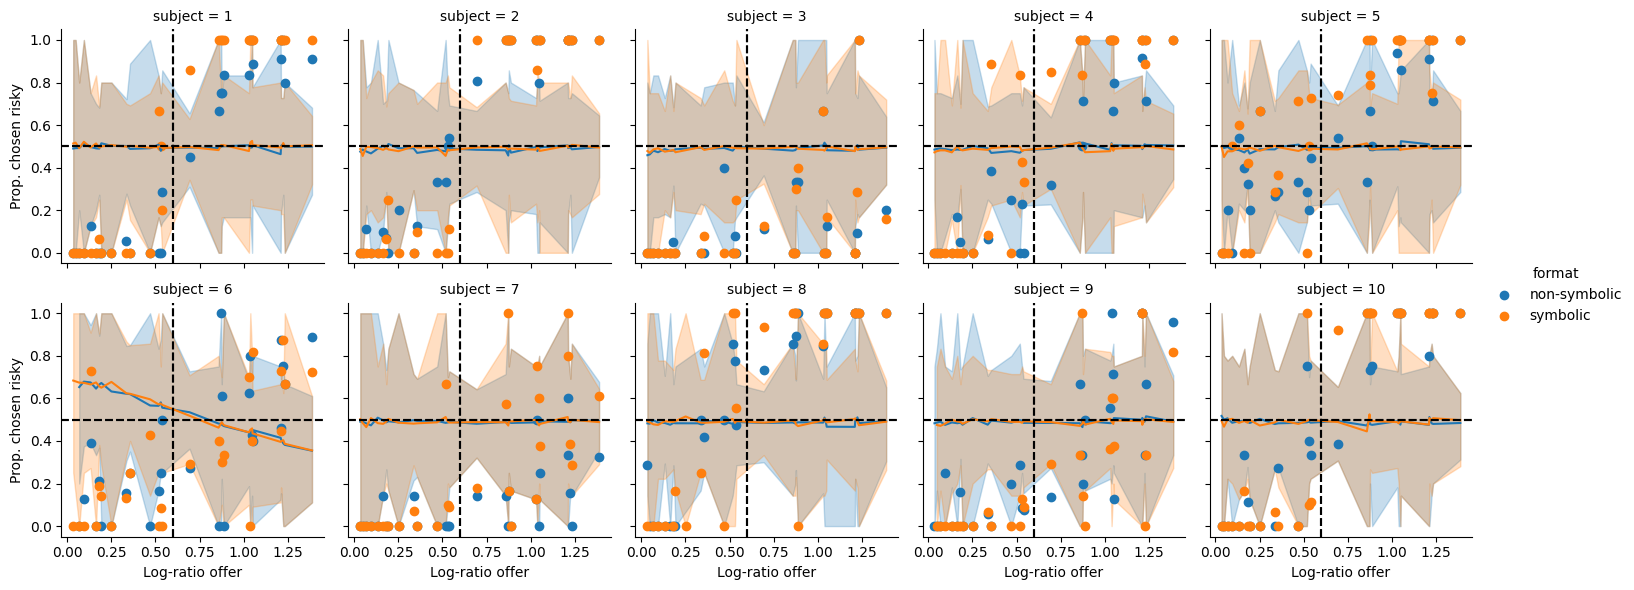

In [68]:
from utils_03 import plot_ppc   
level = 'subject'#'group'
plot_type = 1
var_name = 'll_bernoulli'
col_wrap = 5


plot_ppc(df, ppc, level=level, plot_type=plot_type, var_name=var_name, col_wrap=col_wrap)

In [71]:
from bauer.utils.plotting import plot_ppc, summarize_ppc, plot_prediction, cluster_offers
import matplotlib.pyplot as plt
import seaborn as sns

def plot_ppc(df, ppc, exp_type='magnitude', plot_type=1, var_name='p', level='subject', col_wrap=5, n_clusters=13):

    if exp_type  == 'magnitude':
        x = 'log(n2/n1)'

        if 'log(n2/n1)' not in ppc.index.names:
            if 'frac'  in ppc.index.names:
                ppc['log(n2/n1)'] = np.log(ppc.index.get_level_values('frac'))
            else:
                ppc['log(n2/n1)'] = np.log(ppc.index.get_level_values('n2')) - np.log(ppc.index.get_level_values('n1'))

            ppc.set_index('log(n2/n1)', append=True)

    assert (var_name in ['p', 'll_bernoulli'])

    ppc = ppc.xs(var_name, 0, 'variable').copy()


    df = df.copy()

    # Make sure that we group data from (Roughly) same fractions
    if not (df.groupby(['subject', x]).size().groupby('subject').size() < (n_clusters+1)).all():
        if level == 'subject':
            df[x] = df.groupby(['subject'],
                                            group_keys=False).apply(lambda d: cluster_offers(d, n_clusters, x))
        else:
            df[x] = cluster_offers(df, n_clusters, x)

    if plot_type == 0:
        groupby = [x]
    elif plot_type == 1:
        groupby = [x, 'n1']
    elif plot_type == 2:
        groupby = ['n1']
    else:
        raise NotImplementedError

    if level == 'group':
        ppc = ppc.groupby(['subject']+groupby).mean()

    if level == 'subject':
        groupby = ['subject'] + groupby

    ppc_summary = summarize_ppc(ppc, groupby=groupby)
    p = df.groupby(groupby).mean()[['choice']]
    ppc_summary = ppc_summary.join(p, how='outer').reset_index()

    if plot_type in [0]:
        fac = sns.FacetGrid(ppc_summary,
                            col='subject' if level == 'subject' else None,
                            col_wrap=col_wrap if level == 'subject' else None)
        fac.map_dataframe(plot_prediction, x=x)
        fac.map(plt.scatter, x, 'choice')

    elif plot_type in [1]:
        fac = sns.FacetGrid(ppc_summary,
                            hue='n1',
                            col='subject' if level == 'subject' else None,
                            col_wrap=col_wrap if level == 'subject' else None)
        fac.map_dataframe(plot_prediction, x=x)
        fac.map(plt.scatter, x, 'choice')

    if plot_type in [2]:
        fac = sns.FacetGrid(ppc_summary,
                            col='subject' if level == 'subject' else None,
                            col_wrap=col_wrap if level == 'subject' else None)
        fac.map_dataframe(plot_prediction, x='n1')
        fac.map(plt.scatter, 'n1', 'choice')
    
    fac.add_legend()

    return fac

/Users/mrenke/git/bauer/bauer/utils/bayes.py:38: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


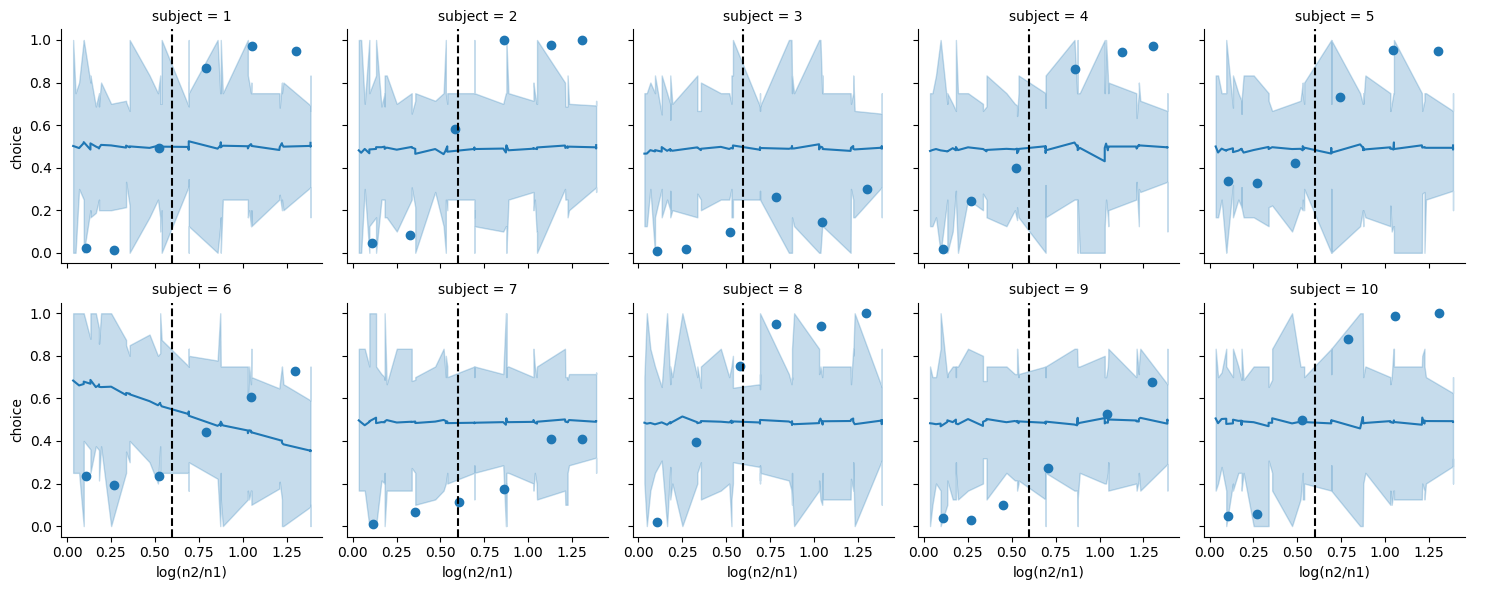

In [74]:
df['log(n2/n1)'] = np.log(df['n2'] / df['n1'])

g = plot_ppc(df, ppc, var_name='ll_bernoulli', plot_type=0, level='subject', n_clusters=6)

g.map(plt.axvline, x=np.log(1./0.55), c='k', ls='--')

             prior_sd          
              hdi_low  hdi_high
subject                        
1        8.316467e-01  4.711101
2        1.022504e+00  4.928301
3        4.199734e-29  3.958654
4        3.558186e-18  4.021369
5        1.639028e-53  4.101005
6        8.513889e-01  4.853323
7        8.453828e-01  4.650259
8        2.231103e-41  4.132472
9        7.271015e-01  4.832701
10       5.199164e-01  4.616786


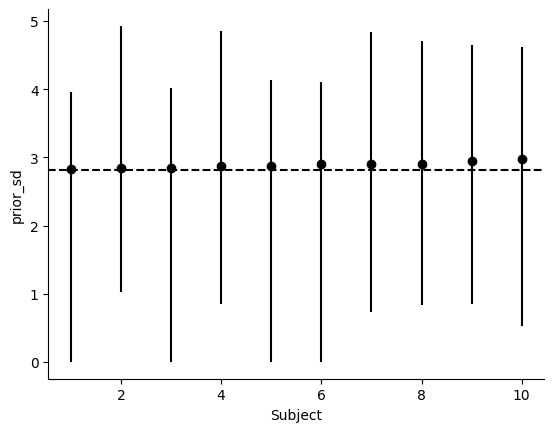

In [26]:
from bauer.utils.plotting import plot_subjectwise_parameters
plot_subjectwise_parameters(idata, parameter='prior_sd')

            rnp          
        hdi_low  hdi_high
subject                  
1           0.0  0.426225
2           0.0  0.392977
3           0.0  0.378763
4           0.0  0.384164
5           0.0  0.379473
6           0.0  0.407491
7           0.0  0.458903
8           0.0  0.431819
9           0.0  0.416308
10          0.0  0.548021


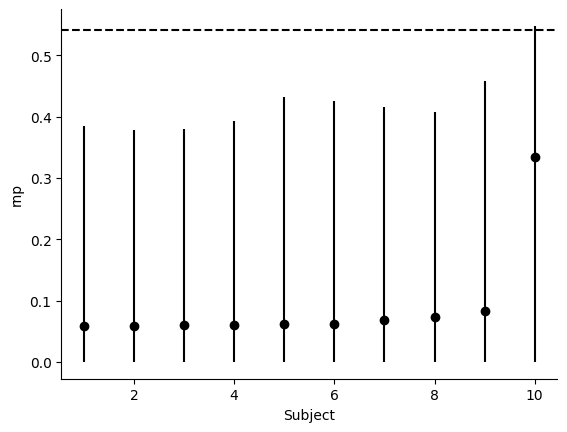

In [27]:
def get_rnp(evidence_sd, prior_std, p=.55):
    beta = prior_std**2 / (evidence_sd**2 + prior_std**2)
    return np.clip(np.exp(-(1./beta) * np.log(1./p)), 0, 1)

idata.posterior['rnp'] = get_rnp(idata.posterior['evidence_sd'], idata.posterior['prior_sd'])
idata.posterior['rnp_mu'] = get_rnp(idata.posterior['evidence_sd_mu'], idata.posterior['prior_sd_mu'])

plot_subjectwise_parameters(idata, parameter='rnp')

In [14]:
from bauer.utils.math import softplus_np

evidence_sd_regressors  Intercept     group
chain draw                                 
0     0                 -1.883095  0.126357
      1                 -1.824620  0.077019
      2                 -1.770035  0.063357
      3                 -1.818687 -0.024233
      4                 -1.849476 -0.016360
...                           ...       ...
3     995               -1.875945  0.109163
      996               -1.875945  0.109163
      997               -1.873207  0.106837
      998               -1.873207  0.106837
      999               -1.876036  0.097155

[4000 rows x 2 columns]

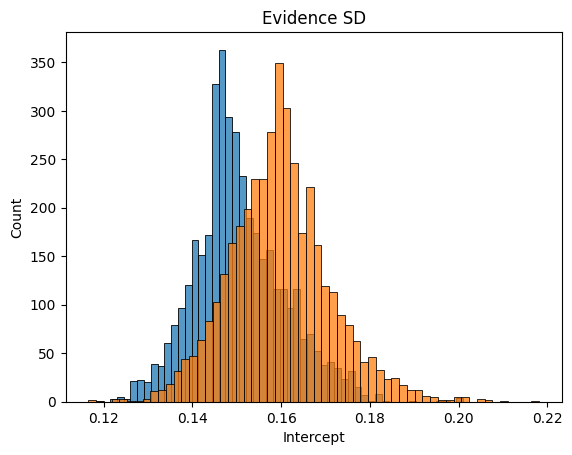

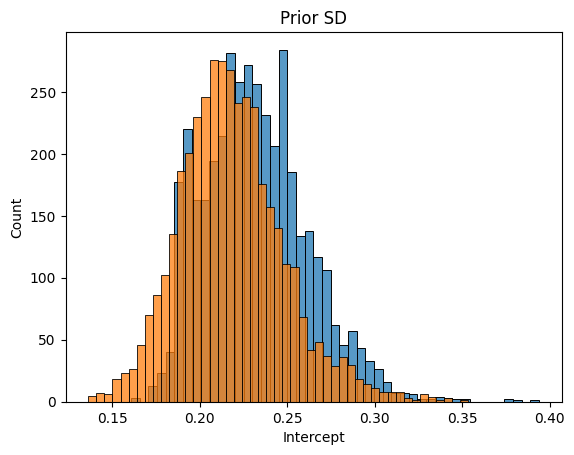

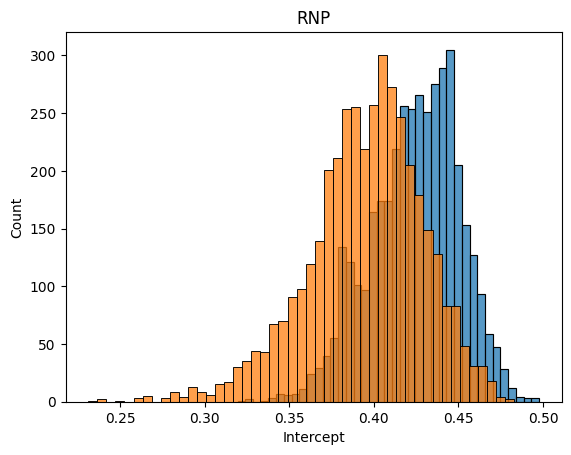

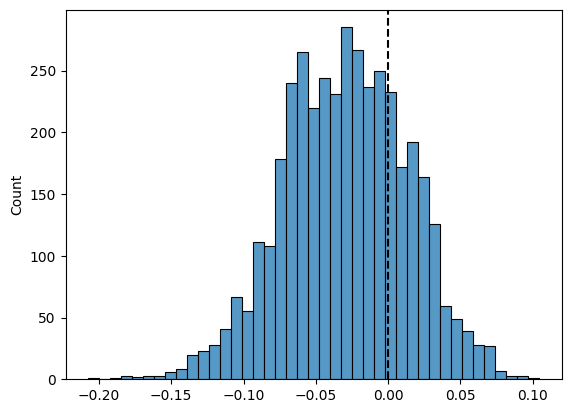

In [30]:
evidence_sd = idata.posterior['evidence_sd_mu'].to_dataframe().unstack('evidence_sd_regressors').droplevel(0, axis=1)

evidence_sd_cc = softplus_np(evidence_sd[('Intercept')])
evidence_sd_dd = softplus_np(evidence_sd[('Intercept')] + evidence_sd[('group')])


prior_sd = idata.posterior['prior_sd_mu'].to_dataframe().unstack('prior_sd_regressors').droplevel(0, axis=1)

prior_sd_cc = softplus_np(prior_sd[('Intercept')])
prior_sd_dd = softplus_np(prior_sd[('Intercept')] + prior_sd[('group')])

sns.histplot(evidence_sd_cc, )
sns.histplot(evidence_sd_dd, )
plt.title('Evidence SD')

plt.figure()
sns.histplot(prior_sd_cc, )
sns.histplot(prior_sd_dd, )
plt.title('Prior SD')

rnp_cc = get_rnp(evidence_sd_cc, prior_sd_cc)
rnp_dd = get_rnp(evidence_sd_dd, prior_sd_dd)

plt.figure()
sns.histplot(rnp_cc, )
sns.histplot(rnp_dd, )
plt.title('RNP')

plt.figure()
sns.histplot(rnp_dd - rnp_cc)

plt.axvline(0.0, c='k', ls='--')


<Axes: ylabel='Count'>

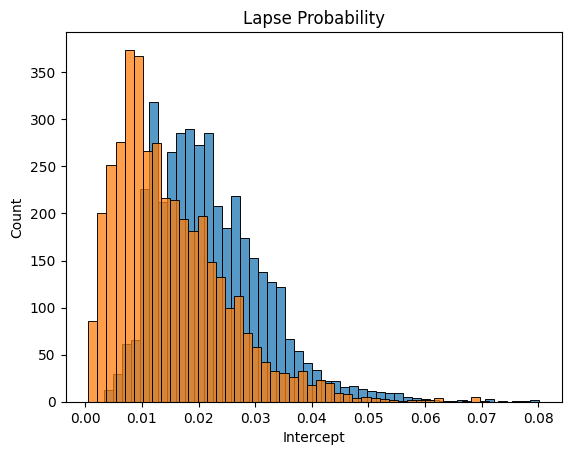

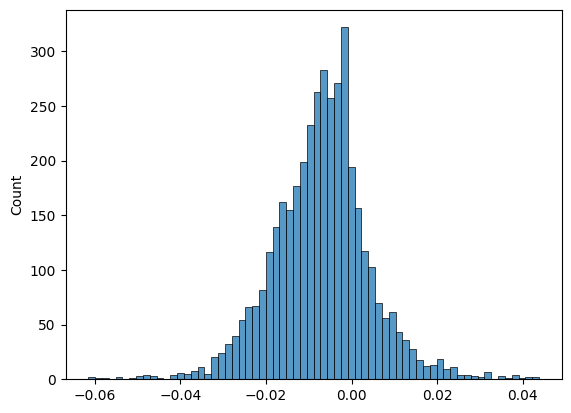

In [31]:
p_lapse = idata.posterior['p_lapse_mu'].to_dataframe().unstack('p_lapse_regressors').droplevel(0, axis=1)

from bauer.utils.math import logistic_np
p_lapse_cc = logistic_np(p_lapse[('Intercept')])
p_lapse_dd = logistic_np(p_lapse[('Intercept')] + p_lapse[('group')])

plt.figure()
sns.histplot(p_lapse_cc, )
sns.histplot(p_lapse_dd, )
plt.title('Lapse Probability')

plt.figure()
sns.histplot(p_lapse_dd - p_lapse_cc)





            rnp          
        hdi_low  hdi_high
subject                  
1           0.0  0.549907
2           0.0  0.549836
3           0.0  0.549927
4           0.0  0.549856
5           0.0  0.549800
...         ...       ...
62          0.0  0.549815
63          0.0  0.549894
64          0.0  0.549389
65          0.0  0.549777
66          0.0  0.549269

[66 rows x 2 columns]


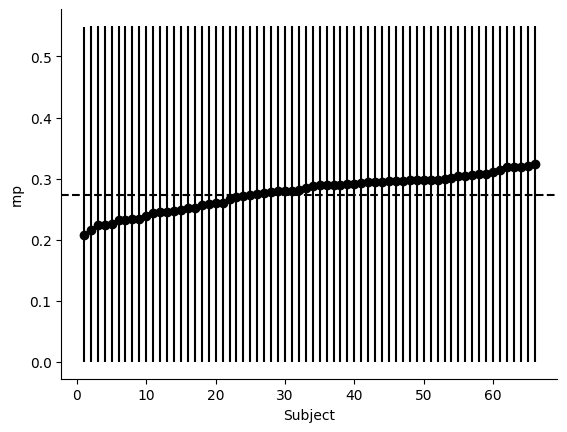

In [8]:
from bauer.utils.plotting import plot_subjectwise_parameters
from utils_02 import get_rnp

idata.posterior['rnp'] = get_rnp(idata.posterior['evidence_sd'], idata.posterior['prior_sd'])
idata.posterior['rnp_mu'] = get_rnp(idata.posterior['evidence_sd_mu'], idata.posterior['prior_sd_mu'])

# plot_subjectwise_parameters(idata, parameter='rnp')

In [9]:
par = 'rnp'
traces = idata.posterior[par+'_mu'].to_dataframe()

In [10]:
traces

rnp_mu
chain draw prior_sd_regressors evidence_sd_regressors               
0     0    Intercept           Intercept                2.138468e-01
                               group                    5.476657e-01
           group               Intercept               2.659749e-186
                               group                    8.053513e-02
      1    Intercept           Intercept                1.957371e-01
...                                                              ...
3     998  group               group                    4.179843e-01
      999  Intercept           Intercept                2.267158e-01
                               group                    5.486943e-01
           group               Intercept                1.372489e-31
                               group                    4.552896e-01

[16000 rows x 1 columns]

Intercept                                                               rnp_mu
chain draw prior_sd_regressors evidence_sd_regressors               
0     0    Intercept           Intercept                2.138468e-01
           group               Intercept               2.659749e-186
      1    Intercept           Intercept                1.957371e-01
           group               Intercept                2.626422e-51
      2    Intercept           Intercept                2.092897e-01
...                                                              ...
3     997  group               Intercept                1.245558e-37
      998  Intercept           Intercept                2.257438e-01
           group               Intercept                1.245558e-37
      999  Intercept           Intercept                2.267158e-01
           group               Intercept                1.372489e-31

[8000 rows x 1 columns]
group                                                          rnp_m

<Figure size 640x480 with 0 Axes>

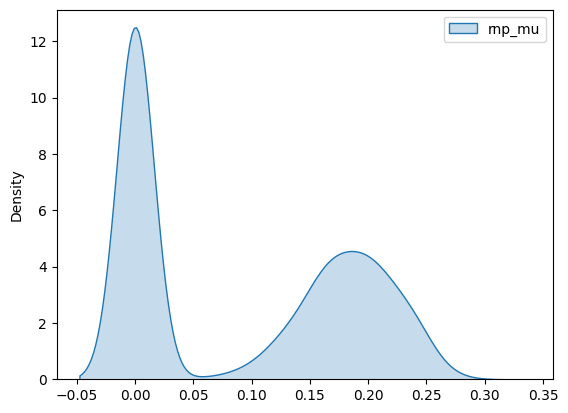

<Figure size 640x480 with 0 Axes>

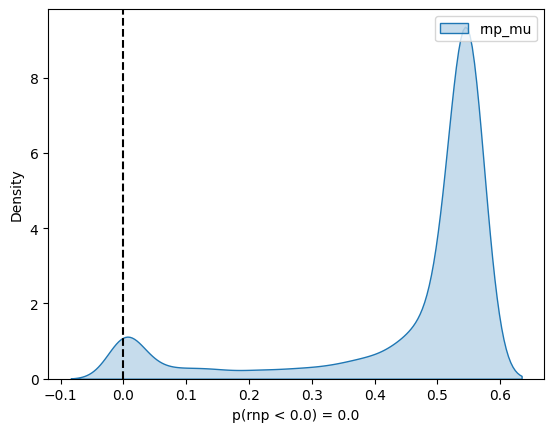

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from bauer.utils.bayes import softplus

#target_folder = op.join(bids_folder, f'derivatives/cogmodels_risk/figures/{model_label}_format-{format}')

par = 'rnp'

for regressor, t in traces.groupby('evidence_sd_regressors'):
            plt.figure()
            t = t.copy()
            print(regressor, t)
            if (par in ['prior_std', 'evidence_sd']) & (regressor == 'Intercept'): #  'risky_prior_std', 'safe_prior_std', 'n1_evidence_sd', 'n2_evidence_sd',
                t = softplus(t)

            plt.figure()
            sns.kdeplot(t, fill=True)
            if regressor != 'Intercept':
                plt.axvline(0.0, c='k', ls='--')
                txt = f'p({par} < 0.0) = {np.round((t.values < 0.0).mean(), 3)}'
                plt.xlabel(txt)


            #plt.savefig(op.join(target_folder, f'group_par-{par}.{regressor}.pdf'))
            #plt.close()
